<a href="https://colab.research.google.com/github/yajima-yasutoshi/DataMining2024/blob/main/20250121/%E5%88%86%E6%9E%90%E8%AA%B2%E9%A1%8C2%E3%81%AE%E8%A7%A3%E7%AD%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# データマイニング第14回

20250114

#本日の講義の目的

分類手法に関する演習を行う。

# 復習

カテゴリ予測を行う方法として以下の3つの手法（アルゴリズム）を説明した。

アルゴリズム | 調整が必要なハイパーパラメータ | 備考
-- | -- | --
ロジスティック回帰 | 正則化項（C） | 説明変数は標準化を行う、カテゴリ数は2つ
決定木 | 木の深さ（max_depth） | 説明変数の標準化は不要、3個以上のカテゴリ分類が可能
ランダムフォレスト |  木の数（n_estimators）、木の深さ（max_depth）、 分割の最小サンプル数（min_samples_split）| 説明変数の標準化は不要、3個以上のカテゴリ分類が可能



## 準備


In [ ]:
# インストール
!pip install japanize-matplotlib

# 必要なライブラリをインポート
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

# 必要なライブラリのインポート
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 分類（ロジスティック回帰）に必要なライブラリー
from sklearn.linear_model import LogisticRegression

# 決定木に必要なライブラリー
from sklearn.tree import DecisionTreeClassifier, plot_tree

# ランダムフォレストに必要なライブラリー
from sklearn.ensemble import RandomForestClassifier

# その他必要なライブラリー
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=4bf6dedb04b4ae9cae265ee24bac48ceb95ad1668c51fff6edd1d6223ac30e8c
  Stored in directory: /root/.cache/pip/wheels/da/a1/71/b8faeb93276fed10edffcca20746f1ef6f8d9e071eee8425fc
Successfully built japanize-matplotlib


# ローン審査データ

本日の資料が以下のサイトに保存してある。

https://github.com/yajima-yasutoshi/shunan-u/tree/main/data

上記のURLより、cleaned_loan_approval_dataset.csv をダウンロードして利用する。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 読み込むファイルを指定する
file_path = '/content/drive/MyDrive/データ/cleaned_loan_approval_dataset.csv'
# dfという変数に読み込む
df = pd.read_csv(file_path)

データの概要を確認する。

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   loan_id                   4269 non-null   int64 
 1   no_of_dependents          4269 non-null   int64 
 2   education                 4269 non-null   object
 3   self_employed             4269 non-null   object
 4   income_annum              4269 non-null   int64 
 5   loan_amount               4269 non-null   int64 
 6   loan_term                 4269 non-null   int64 
 7   cibil_score               4269 non-null   int64 
 8   residential_assets_value  4269 non-null   int64 
 9   commercial_assets_value   4269 non-null   int64 
 10  luxury_assets_value       4269 non-null   int64 
 11  bank_asset_value          4269 non-null   int64 
 12  loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


これは、住宅ローンの審査結果のデータである。
申込者に関するデータおよび、ローン審査の結果(loan_status)が格納されている。



 No | 列名 | 型 | 意味
 -- | -- | --  | --
 0  | loan_id                 | 数値 |  ID番号
 1  | no_of_dependents        | 数値 |   同居している家族の人数
 2  | education               | カテゴリ | 学歴  
 3  |  self_employed          | カテゴリ | 自営業かそうでないか
 4  |  income_annum           | 数値 | 年収
 5  |  loan_amount            | 数値 | ローン金額
 6  |  loan_term              | 数値 | ローン年数
 7  |  cibil_score            | 数値 | スコア
 8  | residential_assets_value  | 数値 | 住居の資産価値
 9  |  commercial_assets_value  | 数値 | 商業用の資産価値
 10 |  luxury_assets_value      | 数値 | 贅沢品の資産価値
 11 |  bank_asset_value         | 数値 | 預貯金額
 12 | loan_status               | カテゴリ| 審査結果


このデータを学習することで、
ローンの審査を行うAIをロジスティック回帰および
決定木によって開発する。

In [ ]:
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


loan_status が2値のデータとなっているか確認し、Approved と Rejected の件数を調べる。

In [ ]:
df['loan_status'].value_counts()

,count
loan_status,
Approved,2656
Rejected,1613


loan_status が Approved と Rejected で分類しloan_term の平均値を求める。
どちらが大きいか調べてみる。

In [ ]:
df.groupby('loan_status')['loan_term'].mean()

,loan_term
loan_status,
Approved,10.397590
Rejected,11.728456


cibil_score の分布の様子を可視化する。ただし、hue = 'loan_status'  を指定して色分けを行う。

<Axes: xlabel='cibil_score', ylabel='Count'>

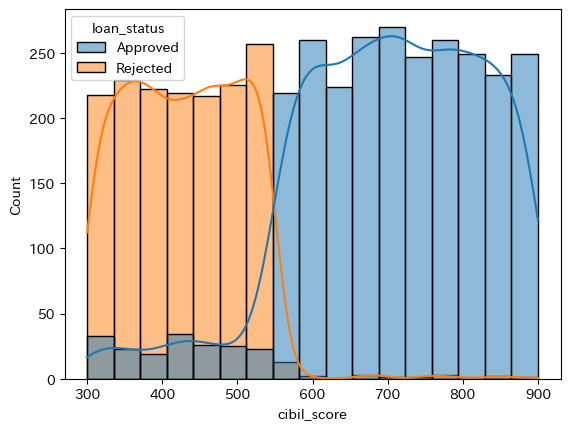

In [ ]:
sns.histplot(data = df, x='cibil_score', hue='loan_status', kde=True)

income_annum の分布の様子を可視化する。ただし、hue = 'loan_status'  を指定して色分けを行う。

<Axes: xlabel='income_annum', ylabel='Count'>

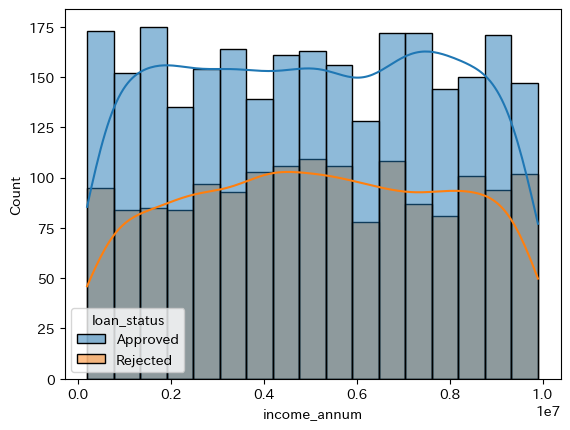

In [ ]:
sns.histplot(data = df, x='income_annum', hue='loan_status', kde=True)

ローン審査の結果（loan_status）を目的変数、
数値型の項目を説明変数としたロジスティック回帰モデルを学習する。説明変数として使う項目は、以下の通りである。

'no_of_dependents', 'income_annum', 'loan_amount',
       'loan_term', 'cibil_score', 'residential_assets_value',
       'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value'

以下のプログラムでは、Xに説明変数、yに目的変数をセットする。
なお、
以下のようにすることで、y は、Approved であれば 1 、そうでないならば
0 となる。

```
y = ( df['loan_status']  == 'Approved' )

```


In [ ]:
X = df[['no_of_dependents', 'income_annum', 'loan_amount',
       'loan_term', 'cibil_score', 'residential_assets_value',
       'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']]
y = ( df['loan_status']  == 'Approved' )

データを学習用と評価用に分割する。
評価用のデータを2割にする。

In [ ]:
# データを学習用と検証用に分割
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=2)

In [ ]:
# 連続変数を標準化
scaler = StandardScaler()
scaler.fit(X_train)

# 学習用データを標準化
X_train_scaled = scaler.transform(X_train)

# 検証用データを標準化
X_validate_scaled = scaler.transform(X_validate)


学習用データを使い、ロジスティック回帰モデルを構築する。A, B を適切に書き換えよ。

In [ ]:
# ロジスティック回帰モデルを作成
model = LogisticRegression()

# モデルを学習する
model.fit(X_train_scaled,y_train)

LogisticRegression()

検証用データを使い予測を計算する。

In [ ]:
# テストデータで予測
y_pred = model.predict(X_validate_scaled)

Accuracy: 0.9180327868852459


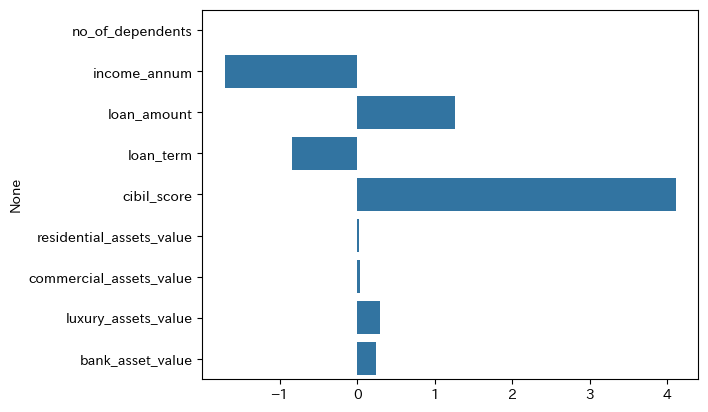

In [ ]:
# 精度を計算
accuracy = accuracy_score(y_validate, y_pred)
print(f'Accuracy: {accuracy}')

# 特徴量の重要度を可視化
sns.barplot(x=model.coef_[0], y=X.columns)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_validate, y_pred)

array([[290,  34],
       [ 36, 494]])

次に、カテゴリ型の項目
'education', 'self_employed'
を One-Hot エンコーディングし、
数値型の説明変数に追加して学習を行う。

In [ ]:
# dfという変数に読み込む
df = pd.read_csv(file_path)

# カテゴリ変数をOne Hot Encoding
df_encoded = pd.get_dummies( df[['education', 'self_employed']] )

# エンコードされたデータと元のデータを結合
df = pd.concat([df, df_encoded], axis=1)

X = df[['no_of_dependents', 'income_annum', 'loan_amount',
       'loan_term', 'cibil_score', 'residential_assets_value',
       'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value',
        'education_Graduate', 'education_Not Graduate', 'self_employed_No','self_employed_Yes']]
y = ( df['loan_status']  == 'Approved' )

In [ ]:
# データを訓練用と検証用に分割
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=1)

scaler = StandardScaler()
scaler.fit(X_train)

# 学習用データを標準化
X_train_scaled = scaler.transform(X_train)

# 検証用データを標準化
X_validate_scaled = scaler.transform(X_validate)

正則化パラメータ C を調整する。
C は、 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 1, 2
を候補として、グリッドサーチを実施する。

In [ ]:
# 必要なライブラリをインポート
from sklearn.model_selection import GridSearchCV

# パラメータグリッドを設定
param_grid = {'C': [ 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 1, 2]}

# グリッドサーチで最適なハイパーパラメータを探す
grid_search = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train.values.ravel() )

# 最適なパラメータでテストデータを評価
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled, y_train.values.ravel() )

y_pred = best_model.predict(X_validate_scaled)
accuracy = accuracy_score(y_validate, y_pred)
print(f"Validation set accuracy: {accuracy}")


Validation set accuracy: 0.9215456674473068


In [ ]:
grid_search.best_params_

{'C': 0.3}

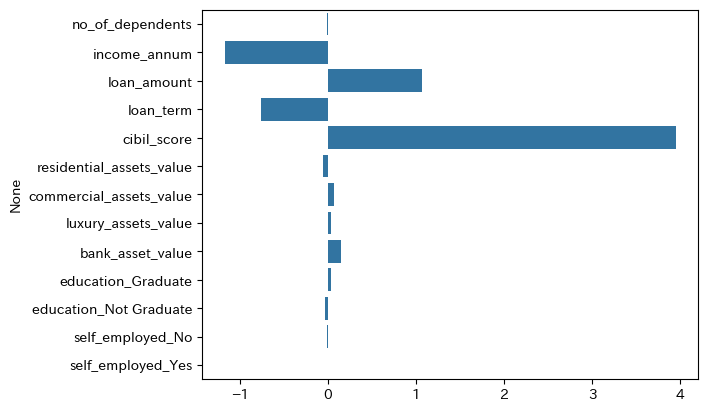

In [ ]:
# 特徴量の重要度を可視化
sns.barplot(x=best_model.coef_[0], y=X.columns)
plt.show()

次に、決定木モデルを構築する。
ハイパーパラメータチューニングは、
max_depth を、2, 3, 4, 5, 10, 20, 50 を候補として実施する。

In [ ]:
# ハイパーパラメータの候補
param_grid = {
    'max_depth': [2, 3, 4, 5, 10, 20, 50]
    }

# グリッドサーチで最適なハイパーパラメータを探す
grid_search = GridSearchCV( DecisionTreeClassifier(random_state=0), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train.values.ravel())

grid_search.best_params_

{'max_depth': 20}

In [ ]:

# 最適なモデルを作成
model = grid_search.best_estimator_
model.fit(X_train, y_train.values.ravel())

# テストデータで予測
y_pred = model.predict(X_validate)

# 精度を計算
accuracy = accuracy_score(y_validate, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9847775175644028


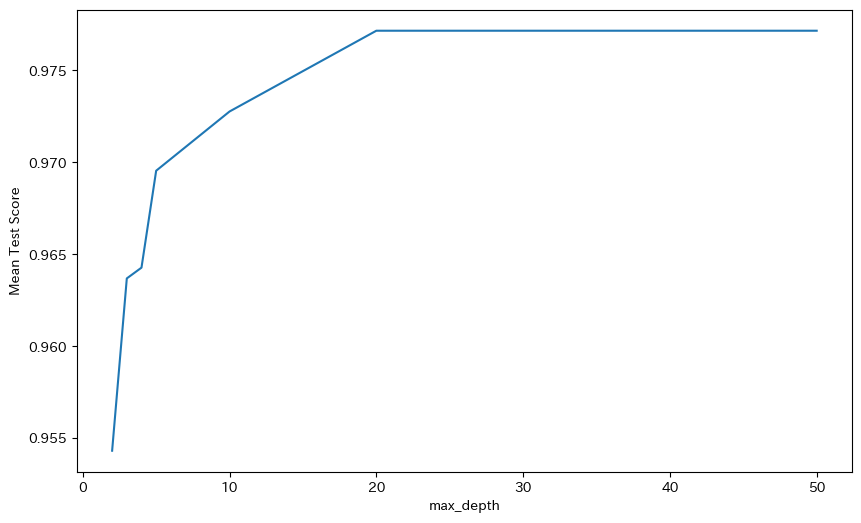

In [ ]:

# 精度が向上する様子をグラフで示す
scores = grid_search.cv_results_['mean_test_score']
plt.figure(figsize=(10, 6))
sns.lineplot(x=param_grid['max_depth'], y=scores)
plt.xlabel('max_depth')
plt.ylabel('Mean Test Score')
# plt.title('Optimizing l2 Penalty with Grid Search')
plt.show()

# 参考

https://www.kaggle.com/datasets/architsharma01/loan-approval-prediction-dataset/
